# **redis-feast-gcp**: 02 - Feature Drift

In this notebook, we will use Feast SDK to load historical data and apply some simple data drift detection techniques. In practice, you will want to enable these metrics to be monitored and acted upon.

**This notebook assumes that you've already set up your feature store and model repo in GCP**


![architecture](img/redis-feast-gcp-architecture.png)

# Fetching Historical Data

Now that our Feast feature store has been provisioned and GCP infra is ready to go, we can use Feast to generate a training dataset. To do this, we need an entity dataframe, alongside the list of features we want.

To make things simpler, we use the [`DataFetcher`](utils/data_fetcher.py) class that wraps Feast, which wraps Redis and BigQuery.

In [1]:
from feature_store.repo import config
from feature_store.utils import (
    DataFetcher,
    storage
)

# Load fs
fs = storage.get_feature_store(
    config_path=config.REPO_CONFIG,
    bucket_name=config.BUCKET_NAME
)

# Load data fetcher
data_fetcher = DataFetcher(fs)

# Feature Data Drift w/ Feast

For data that is based on time series, it's important to consider that different windows of time behave differently due to seasonality and other temporal influences. Concept drift is very possible in these scenarios because the inference/serving (or testing) environment may be very different than the training environment.

Fortunately, with an orchestration layer like **Feast** over Redis & some "offline" source like BigQuery, you can:
- Measure distribution shifts in your historical data
- Detect whether "online" or realtime data is "out of bounds" from some baseline distribution

This is important in order to:
- Make sure that training and testing windows behave similarly
- Identify possible remedies to drift
- Make sure that real time features and model predictions are in line

## Detecting Distribution Shifts

In [2]:
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot

def fetch_window(start, end):
    # Fetch historical data from window
    d = data_fetcher.get_training_data(
        entity_query=f"""
            select
                state,
                date as event_timestamp
            from
                {config.BIGQUERY_DATASET_NAME}.{config.WEEKLY_VACCINATIONS_TABLE}
            where
                date between timestamp('{start.isoformat()}') and timestamp('{end.isoformat()}')
        """
    )

    # Clean up any nulls
    d.dropna(inplace=True)
    d.sort_values(['event_timestamp', 'state'], axis=0, inplace=True)
    d['year'] = start.year
    return d

In [3]:
# Define and fetch windows of data
window_1_start = datetime.strptime('2021-01-01', '%Y-%m-%d')
window_1_end = datetime.strptime('2021-12-31', '%Y-%m-%d')
ds_2021 = fetch_window(window_1_start, window_1_end)

window_2_start = datetime.strptime('2022-01-01', '%Y-%m-%d')
window_2_end = datetime.strptime('2022-12-31', '%Y-%m-%d')
ds_2022 = fetch_window(window_2_start, window_2_end)

In [4]:
ds_2021.head()

,state,event_timestamp,lag_1_vaccine_interest,lag_2_vaccine_interest,lag_1_vaccine_intent,lag_2_vaccine_intent,lag_1_vaccine_safety,lag_2_vaccine_safety,lag_1_weekly_vaccinations_count,lag_2_weekly_vaccinations_count,weekly_vaccinations_count,year
1546,Alabama,2021-01-25 00:00:00+00:00,39.038845,36.094019,12.824061,12.720852,6.473138,5.824231,92719,42991.0,114983,2021
1569,Alaska,2021-01-25 00:00:00+00:00,48.502483,47.591286,15.653407,16.165259,8.311231,9.042923,32578,23733.0,29374,2021
1524,Arizona,2021-01-25 00:00:00+00:00,63.963243,75.229936,25.268439,33.960895,8.403135,8.728861,140680,102381.0,188977,2021
1539,Arkansas,2021-01-25 00:00:00+00:00,38.395392,41.234870,12.547971,12.488109,7.777008,7.896153,82034,168180.0,83994,2021
1564,California,2021-01-25 00:00:00+00:00,60.554451,66.942802,22.073599,25.481500,7.958698,8.674249,773278,509907.0,1078432,2021


In [5]:
ds_2022.head()

,state,event_timestamp,lag_1_vaccine_interest,lag_2_vaccine_interest,lag_1_vaccine_intent,lag_2_vaccine_intent,lag_1_vaccine_safety,lag_2_vaccine_safety,lag_1_weekly_vaccinations_count,lag_2_weekly_vaccinations_count,weekly_vaccinations_count,year
679,Alabama,2022-01-03 00:00:00+00:00,28.305035,23.630124,3.543564,3.373413,3.015033,2.902671,77003,76002,74417,2022
651,Alaska,2022-01-03 00:00:00+00:00,37.255821,29.043778,7.297833,5.720667,3.202091,2.579526,11247,11607,9535,2022
642,Arizona,2022-01-03 00:00:00+00:00,38.162271,31.880088,6.364036,5.430113,3.497884,2.980840,149254,185221,163570,2022
680,Arkansas,2022-01-03 00:00:00+00:00,28.983961,21.760186,3.583835,2.876178,3.049042,2.658123,45633,56598,52749,2022
675,California,2022-01-03 00:00:00+00:00,51.692801,43.844906,10.064004,8.465122,4.109091,3.587646,1026382,1026382,1026382,2022


### Vaccine Demand Example

Given the nature of the global pandemic, we would expect there to be different underlying distributions of feature data between 2021 and 2022.

/tmp/ipykernel_377/657937913.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ds_2021.lag_1_vaccine_interest, label='2021 Vaccine Search Interest')
/tmp/ipykernel_377/657937913.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ds_2022.lag_1_vaccine_interest, label='2022 Vaccine Search Inter

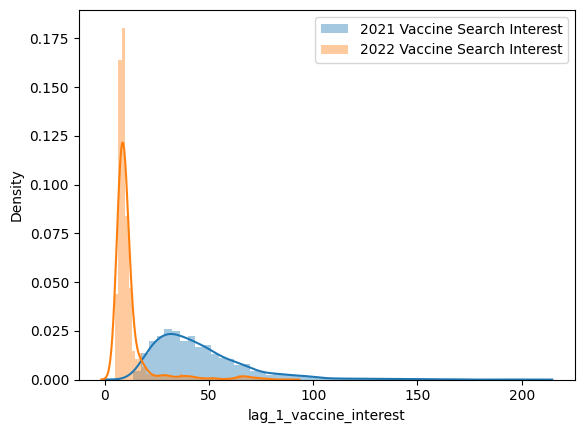

In [6]:
sns.distplot(ds_2021.lag_1_vaccine_interest, label='2021 Vaccine Search Interest')
sns.distplot(ds_2022.lag_1_vaccine_interest, label='2022 Vaccine Search Interest')
pyplot.legend()
pyplot.show()

/tmp/ipykernel_377/1791990679.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ds_2021.lag_1_vaccine_intent, label='2021 Vaccine Search Intent')
/tmp/ipykernel_377/1791990679.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ds_2022.lag_1_vaccine_intent, label='2022 Vaccine Search Intent')


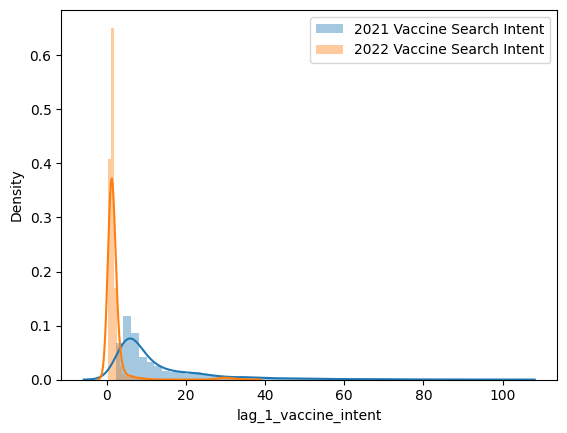

In [7]:
sns.distplot(ds_2021.lag_1_vaccine_intent, label='2021 Vaccine Search Intent')
sns.distplot(ds_2022.lag_1_vaccine_intent, label='2022 Vaccine Search Intent')
pyplot.legend()
pyplot.show()

/tmp/ipykernel_377/999025459.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ds_2021.lag_1_vaccine_safety, label='2021 Vaccine Search Safety')
/tmp/ipykernel_377/999025459.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ds_2022.lag_1_vaccine_safety, label='2022 Vaccine Search Safety')


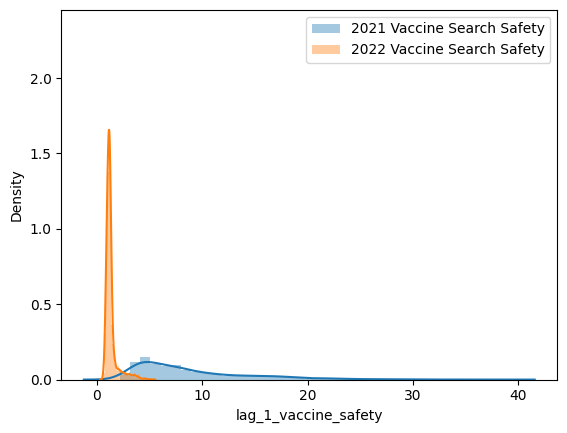

In [8]:
sns.distplot(ds_2021.lag_1_vaccine_safety, label='2021 Vaccine Search Safety')
sns.distplot(ds_2022.lag_1_vaccine_safety, label='2022 Vaccine Search Safety')
pyplot.legend()
pyplot.show()

/tmp/ipykernel_377/3417451842.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ds_2021.weekly_vaccinations_count, label='2021 Weekly Vaccinations Count')
/tmp/ipykernel_377/3417451842.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ds_2022.weekly_vaccinations_count, label='2022 Weekly Vac

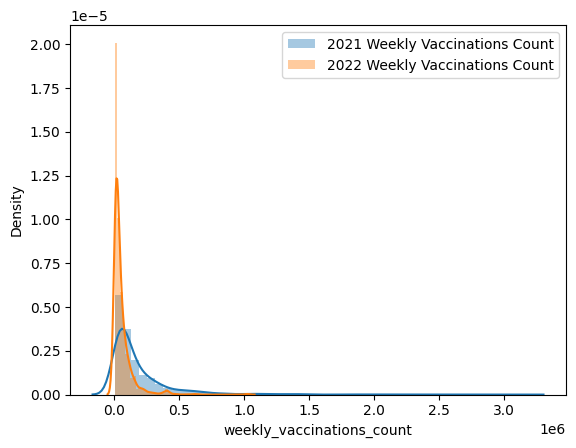

In [9]:
sns.distplot(ds_2021.weekly_vaccinations_count, label='2021 Weekly Vaccinations Count')
sns.distplot(ds_2022.weekly_vaccinations_count, label='2022 Weekly Vaccinations Count')
pyplot.legend()
pyplot.show()

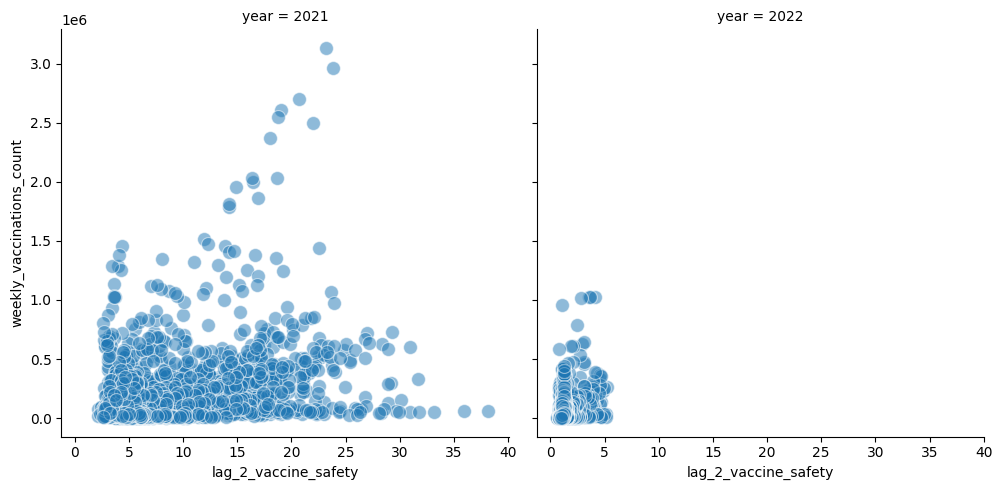

In [10]:
# look at relationships
import pandas as pd

g = sns.FacetGrid(pd.concat([ds_2021, ds_2022]), col="year", height=5)
g.map(sns.scatterplot, "lag_2_vaccine_safety", "weekly_vaccinations_count", s=100, alpha=.5)
g.add_legend()

Next we'll use a tool like evidently to cross reference data drift for all features...

In [ ]:
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataDriftTab, CatTargetDriftTab

In [ ]:
ds_2021['target'] = ds_2021.weekly_vaccinations_count
ds_2022['target'] = ds_2022.weekly_vaccinations_count


data_drift_report = Dashboard(tabs=[DataDriftTab(verbose_level=True), 
                                    CatTargetDriftTab(verbose_level=True)])
data_drift_report.calculate(ds_2021, ds_2022, column_mapping = None)
data_drift_report.show(mode="inline")